In [5]:
# CPU libraries
import os
import json
from glob import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil

import json
from PIL import Image




In [6]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [7]:

base_dir = './data'  # Replace with actual base directory


In [8]:
import os

def iterate_through_folders(base_dir):
    """
    Iterates through folders with the structure ./data/<site>/<floor>/<subdirectory>/<filename>.txt
    and returns lists of floors and filenames.

    Args:
        base_dir: The base directory to start the search from.

    Returns:
        tuple: A tuple containing three elements:
            - sitenames: A set of unique site names found.
            - floors: A list of unique floor names found.
            - filenames: A list of all .txt filenames found.
    """

    floors = set()  # Use a set to store unique floor names
    filenames = []
    sitenames = set()

    for site_dir in os.listdir(base_dir):
        site_path = os.path.join(base_dir, site_dir)
        if os.path.isdir(site_path):  # Check if it's a directory (site)
            sitenames.add(site_dir)
            for floor_dir in os.listdir(site_path):
                floor_path = os.path.join(site_path, floor_dir)
                if os.path.isdir(floor_path):  # Check if it's a directory (floor)
                    floors.add(floor_dir)  # Add floor name to the set
                    for sub_dir in os.listdir(floor_path):
                        sub_dir_path = os.path.join(floor_path, sub_dir)
                        if os.path.isdir(sub_dir_path):  # Check if it's a directory (subdirectory)
                            for filename in os.listdir(sub_dir_path):
                                if filename.endswith('.txt'):  # Check for .txt files
                                    # Append the full file path including subdirectory
                                    filenames.append(os.path.join(sub_dir_path, filename))

    return sitenames, list(floors), filenames  # Convert sets to lists


# Example usage
sitenames, floors, filenames = iterate_through_folders(base_dir)

print("Floors:", floors)
print("Number of Floors:", len(floors))
print("Filenames:", filenames)
print("Number of Files:", len(filenames))   
print("Sitenames:", sitenames) 
print("Number of Sitenames:", len(sitenames))


Floors: ['F1', 'F3', 'B1', 'F4', 'F7', 'F8', 'F2', 'F5', 'F6']
Number of Floors: 9
Filenames: ['./data\\site1\\B1\\path_data_files\\5dda14979191710006b5720e.txt', './data\\site1\\B1\\path_data_files\\5dda1499c5b77e0006b1752f.txt', './data\\site1\\B1\\path_data_files\\5dda149dc5b77e0006b17531.txt', './data\\site1\\B1\\path_data_files\\5dda149f9191710006b57212.txt', './data\\site1\\B1\\path_data_files\\5dda14a2c5b77e0006b17533.txt', './data\\site1\\B1\\path_data_files\\5dda14a39191710006b57214.txt', './data\\site1\\B1\\path_data_files\\5dda14a5c5b77e0006b17535.txt', './data\\site1\\B1\\path_data_files\\5dda14a79191710006b57216.txt', './data\\site1\\B1\\path_data_files\\5dda14aac5b77e0006b17537.txt', './data\\site1\\B1\\path_data_files\\5dda14ab9191710006b57218.txt', './data\\site1\\B1\\path_data_files\\5dda14af9191710006b5721a.txt', './data\\site1\\B1\\path_data_files\\5dda14b1c5b77e0006b1753b.txt', './data\\site1\\B1\\path_data_files\\5dda14b49191710006b5721c.txt', './data\\site1\\B1\\p

In [9]:
from dataclasses import dataclass
import numpy as np
import os
import pandas as pd

@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray
    site: str
    floor: str

def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    # Extract site and floor from the filename
    parts = data_filename.split(os.sep)
    site = parts[-4]
    floor = parts[-3]

    current_waypoint = None

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')
        timestamp = int(line_data[0])

        if line_data[1] == 'TYPE_WAYPOINT':
            current_waypoint = [float(line_data[2]), float(line_data[3])]
            waypoint.append([timestamp] + current_waypoint)
        else:
            waypoint_data = current_waypoint if current_waypoint else [None, None]

            if line_data[1] == 'TYPE_ACCELEROMETER':
                acce.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
                acce_uncali.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_GYROSCOPE':
                gyro.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
                gyro_uncali.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_MAGNETIC_FIELD':
                magn.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
                magn_uncali.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_ROTATION_VECTOR':
                ahrs.append([timestamp] + [float(x) for x in line_data[2:5]] + waypoint_data)
            elif line_data[1] == 'TYPE_WIFI':
                wifi.append([timestamp, line_data[2], line_data[3], int(line_data[4]), int(line_data[6])] + waypoint_data)
            elif line_data[1] == 'TYPE_BEACON':
                ibeacon.append([timestamp, '_'.join([line_data[2], line_data[3], line_data[4]]), int(line_data[6])] + waypoint_data)

    return ReadData(
        np.array(acce),
        np.array(acce_uncali),
        np.array(gyro),
        np.array(gyro_uncali),
        np.array(magn),
        np.array(magn_uncali),
        np.array(ahrs),
        np.array(wifi),
        np.array(ibeacon),
        np.array(waypoint),
        site,
        floor
    )

def process_all_files(base_dir):
    all_data = []
    
    for site_dir in os.listdir(base_dir):
        site_path = os.path.join(base_dir, site_dir)
        if os.path.isdir(site_path):  # Check if it's a directory (site level)
            for floor_dir in os.listdir(site_path):
                floor_path = os.path.join(site_path, floor_dir)
                if os.path.isdir(floor_path):  # Check if it's a directory (floor level)
                    for sub_dir in os.listdir(floor_path):
                        sub_dir_path = os.path.join(floor_path, sub_dir)
                        if os.path.isdir(sub_dir_path):  # Check if it's a directory (subdirectory level)
                            for filename in os.listdir(sub_dir_path):
                                if filename.endswith('.txt'):  # Only process .txt files
                                    file_path = os.path.join(sub_dir_path, filename)
                                    read_data = read_data_file(file_path)  # Process the file
                                    all_data.append(read_data)  # Append the processed data to the list
                                    
    return all_data

# def process_all_files(base_dir):
#     all_data = []
    
#     for site_dir in os.listdir(base_dir):
#         site_path = os.path.join(base_dir, site_dir)
#         if os.path.isdir(site_path):
#             for floor_dir in os.listdir(site_path):
#                 floor_path = os.path.join(site_path, floor_dir)
#                 if os.path.isdir(floor_path):
#                     for filename in os.listdir(floor_path):
#                         if filename.endswith('.txt'):
#                             file_path = os.path.join(floor_path, filename)
#                             read_data = read_data_file(file_path)
#                             all_data.append(read_data)
    
#     return all_data

def create_combined_dataframe(all_data):
    dataframes = []
    
    for data in all_data:
        sensor_data = [
            ('ACCELEROMETER', data.acce, ['timestamp', 'acce_x', 'acce_y', 'acce_z', 'waypoint_x', 'waypoint_y']),
            ('ACCELEROMETER_UNCALIBRATED', data.acce_uncali, ['timestamp', 'acce_uncali_x', 'acce_uncali_y', 'acce_uncali_z', 'waypoint_x', 'waypoint_y']),
            ('GYROSCOPE', data.gyro, ['timestamp', 'gyro_x', 'gyro_y', 'gyro_z', 'waypoint_x', 'waypoint_y']),
            ('GYROSCOPE_UNCALIBRATED', data.gyro_uncali, ['timestamp', 'gyro_uncali_x', 'gyro_uncali_y', 'gyro_uncali_z', 'waypoint_x', 'waypoint_y']),
            ('MAGNETIC_FIELD', data.magn, ['timestamp', 'magn_x', 'magn_y', 'magn_z', 'waypoint_x', 'waypoint_y']),
            ('MAGNETIC_FIELD_UNCALIBRATED', data.magn_uncali, ['timestamp', 'magn_uncali_x', 'magn_uncali_y', 'magn_uncali_z', 'waypoint_x', 'waypoint_y']),
            ('ROTATION_VECTOR', data.ahrs, ['timestamp', 'ahrs_x', 'ahrs_y', 'ahrs_z', 'waypoint_x', 'waypoint_y']),
            ('WIFI', data.wifi, ['timestamp', 'ssid', 'bssid', 'rssi', 'lastseen_ts', 'waypoint_x', 'waypoint_y']),
            ('BEACON', data.ibeacon, ['timestamp', 'uuid_major_minor', 'rssi', 'waypoint_x', 'waypoint_y']),
            ('WAYPOINT', data.waypoint, ['timestamp', 'waypoint_x', 'waypoint_y'])
        ]
        
        for sensor_type, sensor_array, columns in sensor_data:
            if sensor_array.size > 0:
                df = pd.DataFrame(sensor_array, columns=columns)
                df['sensor_type'] = sensor_type
                df['site'] = data.site
                df['floor'] = data.floor
                dataframes.append(df)
    
    if dataframes:
        final_df = pd.concat(dataframes, ignore_index=True)
    else:
        final_df = pd.DataFrame()
    
    return final_df

# Usage
base_dir = "./data"  # Adjust this to your actual base directory
all_data = process_all_files(base_dir)
final_dataframe = create_combined_dataframe(all_data)

# Display the first few rows and shape of the final DataFrame
print(final_dataframe.head())
print(f"\nFinal DataFrame shape: {final_dataframe.shape}")

# Optional: Save to CSV
# final_dataframe.to_csv('all_sensor_data.csv', index=False)

         timestamp    acce_x    acce_y     acce_z waypoint_x waypoint_y  \
0  1574572522414.0 -1.657410 -0.032135  17.939987  208.86206  216.74796   
1  1574572522434.0 -1.486832  0.351547  17.318680  208.86206  216.74796   
2  1574572522454.0 -1.620300  0.512558  15.494308  208.86206  216.74796   
3  1574572522474.0 -1.705902  0.053467  14.442657  208.86206  216.74796   
4  1574572522494.0 -1.867508 -0.087204  12.749954  208.86206  216.74796   

     sensor_type   site floor  acce_uncali_x  ...  magn_uncali_y  \
0  ACCELEROMETER  site1    B1            NaN  ...            NaN   
1  ACCELEROMETER  site1    B1            NaN  ...            NaN   
2  ACCELEROMETER  site1    B1            NaN  ...            NaN   
3  ACCELEROMETER  site1    B1            NaN  ...            NaN   
4  ACCELEROMETER  site1    B1            NaN  ...            NaN   

   magn_uncali_z  ahrs_x  ahrs_y  ahrs_z  ssid  bssid  rssi  lastseen_ts  \
0            NaN     NaN     NaN     NaN   NaN    NaN   NaN     

In [10]:
final_dataframe.tail()

timestamp  acce_x  acce_y  acce_z waypoint_x waypoint_y  \
24906767    1574679872187     NaN     NaN     NaN  154.20166  166.74393   
24906768  1574679862183.0     NaN     NaN     NaN  147.50182   172.4349   
24906769  1574679866635.0     NaN     NaN     NaN  150.93529    167.373   
24906770  1574679868778.0     NaN     NaN     NaN  154.20166  166.74393   
24906771  1574679872951.0     NaN     NaN     NaN  156.90472  161.96008   

         sensor_type   site floor  acce_uncali_x  ...  magn_uncali_y  \
24906767      BEACON  site2    F8            NaN  ...            NaN   
24906768    WAYPOINT  site2    F8            NaN  ...            NaN   
24906769    WAYPOINT  site2    F8            NaN  ...            NaN   
24906770    WAYPOINT  site2    F8            NaN  ...            NaN   
24906771    WAYPOINT  site2    F8            NaN  ...            NaN   

          magn_uncali_z  ahrs_x  ahrs_y  ahrs_z  ssid  bssid  rssi  \
24906767            NaN     NaN     NaN     NaN   NaN    NaN   -80   
24906768            NaN     NaN     NaN     NaN   NaN    NaN   NaN   
24906769            NaN     NaN     NaN     NaN   NaN    NaN   NaN   
24906770            NaN     NaN     NaN     NaN   NaN    NaN   NaN   
24906771            NaN     NaN     NaN     NaN   NaN    NaN   NaN   

          lastseen_ts                                  uuid_major_minor  
24906767          NaN  991CB71E-850B-C24D-4047-90A0ACAA4951_45830_56687  
24906768          NaN                                               NaN  
24906769          NaN                                               NaN  
24906770          NaN                                               NaN  
24906771          NaN                                               NaN  

[5 rows x 32 columns]

In [11]:
# Optional: Save to CSV
final_dataframe.to_csv('all_sensor_data.csv', index=False)

In [12]:
final_dataframe['waypoint_x'].count()

np.int64(24906772)

In [13]:
final_dataframe['sensor_type'].unique()



array(['ACCELEROMETER', 'ACCELEROMETER_UNCALIBRATED', 'GYROSCOPE',
       'GYROSCOPE_UNCALIBRATED', 'MAGNETIC_FIELD',
       'MAGNETIC_FIELD_UNCALIBRATED', 'ROTATION_VECTOR', 'WIFI', 'BEACON',
       'WAYPOINT'], dtype=object)

In [14]:
final_dataframe[final_dataframe['sensor_type']=='WIFI']['ssid'].value_counts()


ssid
                    1614137
JOY CITY             598033
intime_lease         461728
intime_free          454101
intime_office        441582
                     ...   
360免费WiFi-KC              1
MB Hotspot 42972          1
  小米共享WiFi_CBE1           1
vivo X20                  1
STH_plus                  1
Name: count, Length: 1936, dtype: int64

In [15]:
final_dataframe['bssid'].nunique()

8445

In [16]:
final_dataframe[final_dataframe['bssid']=='12:74:9c:2d:06:cf']

timestamp  acce_x  acce_y  acce_z waypoint_x waypoint_y  \
2453942   1574560096191     NaN     NaN     NaN    169.142   52.48631   
2454474   1574560098704     NaN     NaN     NaN    169.142   52.48631   
2454989   1574560101135     NaN     NaN     NaN  179.17696   49.93896   
2455498   1574560103582     NaN     NaN     NaN  179.52501  51.828476   
2455981   1574560105915     NaN     NaN     NaN   179.9052   54.11242   
...                 ...     ...     ...     ...        ...        ...   
15970386  1575546670515     NaN     NaN     NaN  187.05292  53.975544   
15970763  1575546672707     NaN     NaN     NaN  187.05292  53.975544   
15971155  1575546674942     NaN     NaN     NaN  187.05292  53.975544   
15971563  1575546677109     NaN     NaN     NaN  187.05292  53.975544   
15971976  1575546679337     NaN     NaN     NaN  187.05292  53.975544   

         sensor_type   site floor  acce_uncali_x  ...  magn_uncali_y  \
2453942         WIFI  site1    F1            NaN  ...            NaN   
2454474         WIFI  site1    F1            NaN  ...            NaN   
2454989         WIFI  site1    F1            NaN  ...            NaN   
2455498         WIFI  site1    F1            NaN  ...            NaN   
2455981         WIFI  site1    F1            NaN  ...            NaN   
...              ...    ...   ...            ...  ...            ...   
15970386        WIFI  site1    F4            NaN  ...            NaN   
15970763        WIFI  site1    F4            NaN  ...            NaN   
15971155        WIFI  site1    F4            NaN  ...            NaN   
15971563        WIFI  site1    F4            NaN  ...            NaN   
15971976        WIFI  site1    F4            NaN  ...            NaN   

          magn_uncali_z  ahrs_x  ahrs_y  ahrs_z          ssid  \
2453942             NaN     NaN     NaN     NaN  intime_lease   
2454474             NaN     NaN     NaN     NaN  intime_lease   
2454989             NaN     NaN     NaN     NaN  intime_lease   
2455498             NaN     NaN     NaN     NaN  intime_lease   
2455981             NaN     NaN     NaN     NaN  intime_lease   
...                 ...     ...     ...     ...           ...   
15970386            NaN     NaN     NaN     NaN  intime_lease   
15970763            NaN     NaN     NaN     NaN  intime_lease   
15971155            NaN     NaN     NaN     NaN  intime_lease   
15971563            NaN     NaN     NaN     NaN  intime_lease   
15971976            NaN     NaN     NaN     NaN  intime_lease   

                      bssid  rssi    lastseen_ts  uuid_major_minor  
2453942   12:74:9c:2d:06:cf   -89  1574560095244               NaN  
2454474   12:74:9c:2d:06:cf   -89  1574560095244               NaN  
2454989   12:74:9c:2d:06:cf   -89  1574560095245               NaN  
2455498   12:74:9c:2d:06:cf   -89  1574560095245               NaN  
2455981   12:74:9c:2d:06:cf   -89  1574560095244               NaN  
...                     ...   ...            ...               ...  
15970386  12:74:9c:2d:06:cf   -88  1575546667840               NaN  
15970763  12:74:9c:2d:06:cf   -88  1575546667841               NaN  
15971155  12:74:9c:2d:06:cf   -88  1575546667841               NaN  
15971563  12:74:9c:2d:06:cf   -88  1575546667840               NaN  
15971976  12:74:9c:2d:06:cf   -88  1575546667840               NaN  

[5097 rows x 32 columns]

In [17]:
final_dataframe[final_dataframe['sensor_type']=='WIFI']['ssid'].nunique()

1936

In [18]:
final_dataframe[final_dataframe['sensor_type']=='WIFI']['bssid'].value_counts()



bssid
12:74:9c:2d:06:cf    5097
0e:74:9c:2d:06:cf    5082
1e:74:9c:2d:06:cf    5082
06:74:9c:2d:06:cf    5072
0a:74:9c:2d:06:cf    5069
                     ... 
d0:76:e7:4b:82:18       1
9c:a5:25:13:eb:84       1
9a:5f:d3:3b:19:0f       1
28:a6:db:e0:ff:f2       1
88:f8:72:de:77:86       1
Name: count, Length: 8445, dtype: int64

In [19]:
final_dataframe[final_dataframe['sensor_type']=='WIFI']['bssid'].nunique()


8445

In [20]:
final_dataframe.columns

Index(['timestamp', 'acce_x', 'acce_y', 'acce_z', 'waypoint_x', 'waypoint_y',
       'sensor_type', 'site', 'floor', 'acce_uncali_x', 'acce_uncali_y',
       'acce_uncali_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_uncali_x',
       'gyro_uncali_y', 'gyro_uncali_z', 'magn_x', 'magn_y', 'magn_z',
       'magn_uncali_x', 'magn_uncali_y', 'magn_uncali_z', 'ahrs_x', 'ahrs_y',
       'ahrs_z', 'ssid', 'bssid', 'rssi', 'lastseen_ts', 'uuid_major_minor'],
      dtype='object')

In [21]:
final_dataframe[final_dataframe['sensor_type']=='WIFI']['rssi'].value_counts()



rssi
-87    317691
-88    311830
-86    304026
-85    275432
-89    257811
        ...  
-23         3
-19         1
-11         1
-10         1
-14         1
Name: count, Length: 90, dtype: int64

In [22]:
final_dataframe['floor'].value_counts()

floor
F1    5645161
F3    4745400
F2    4335318
F4    3730239
B1    3351460
F6    1190698
F7     653011
F5     640598
F8     614887
Name: count, dtype: int64

In [23]:
final_dataframe[final_dataframe['sensor_type']=='WIFI']

timestamp  acce_x  acce_y  acce_z waypoint_x waypoint_y  \
6181      1574572524224     NaN     NaN     NaN  208.86206  216.74796   
6182      1574572524224     NaN     NaN     NaN  208.86206  216.74796   
6183      1574572524224     NaN     NaN     NaN  208.86206  216.74796   
6184      1574572524224     NaN     NaN     NaN  208.86206  216.74796   
6185      1574572524224     NaN     NaN     NaN  208.86206  216.74796   
...                 ...     ...     ...     ...        ...        ...   
24906702  1574679871683     NaN     NaN     NaN  154.20166  166.74393   
24906703  1574679871683     NaN     NaN     NaN  154.20166  166.74393   
24906704  1574679871683     NaN     NaN     NaN  154.20166  166.74393   
24906705  1574679871683     NaN     NaN     NaN  154.20166  166.74393   
24906706  1574679871683     NaN     NaN     NaN  154.20166  166.74393   

         sensor_type   site floor  acce_uncali_x  ...  magn_uncali_y  \
6181            WIFI  site1    B1            NaN  ...            NaN   
6182            WIFI  site1    B1            NaN  ...            NaN   
6183            WIFI  site1    B1            NaN  ...            NaN   
6184            WIFI  site1    B1            NaN  ...            NaN   
6185            WIFI  site1    B1            NaN  ...            NaN   
...              ...    ...   ...            ...  ...            ...   
24906702        WIFI  site2    F8            NaN  ...            NaN   
24906703        WIFI  site2    F8            NaN  ...            NaN   
24906704        WIFI  site2    F8            NaN  ...            NaN   
24906705        WIFI  site2    F8            NaN  ...            NaN   
24906706        WIFI  site2    F8            NaN  ...            NaN   

          magn_uncali_z  ahrs_x  ahrs_y  ahrs_z                        ssid  \
6181                NaN     NaN     NaN     NaN                  intime_pos   
6182                NaN     NaN     NaN     NaN               intime_office   
6183                NaN     NaN     NaN     NaN        cloud time_license_5   
6184                NaN     NaN     NaN     NaN                 intime_free   
6185                NaN     NaN     NaN     NaN                intime_lease   
...                 ...     ...     ...     ...                         ...   
24906702            NaN     NaN     NaN     NaN                               
24906703            NaN     NaN     NaN     NaN  YOCDke1gb7uIESyyPtCXuQRrQ7   
24906704            NaN     NaN     NaN     NaN                               
24906705            NaN     NaN     NaN     NaN                      LinkUP   
24906706            NaN     NaN     NaN     NaN                        BONA   

                      bssid  rssi    lastseen_ts  uuid_major_minor  
6181      06:74:9c:2e:9e:f3   -42  1574572523661               NaN  
6182      0a:74:9c:2e:9e:f3   -42  1574572523662               NaN  
6183      1e:74:9c:2e:9e:f3   -43  1574572523664               NaN  
6184      0e:74:9c:2e:9e:f3   -43  1574572523662               NaN  
6185      12:74:9c:2e:9e:f3   -43  1574572523662               NaN  
...                     ...   ...            ...               ...  
24906702  04:40:a9:f9:d8:a2   -90  1574679854198               NaN  
24906703  a4:9b:4f:16:79:98   -90  1574679870165               NaN  
24906704  04:40:a9:f9:d8:a1   -91  1574679868738               NaN  
24906705  f4:28:53:d9:c9:a8   -91  1574679869832               NaN  
24906706  88:df:9e:c5:ce:5f   -93  1574679855268               NaN  

[5674633 rows x 32 columns]

In [24]:
final_dataframe.groupby(['site','floor'])['bssid'].nunique()

site   floor
site1  B1       1452
       F1       2524
       F2       2272
       F3       2209
       F4       1982
site2  B1       1054
       F1       2524
       F2       2187
       F3       2048
       F4       1961
       F5       1960
       F6       2047
       F7       1636
       F8        934
Name: bssid, dtype: int64

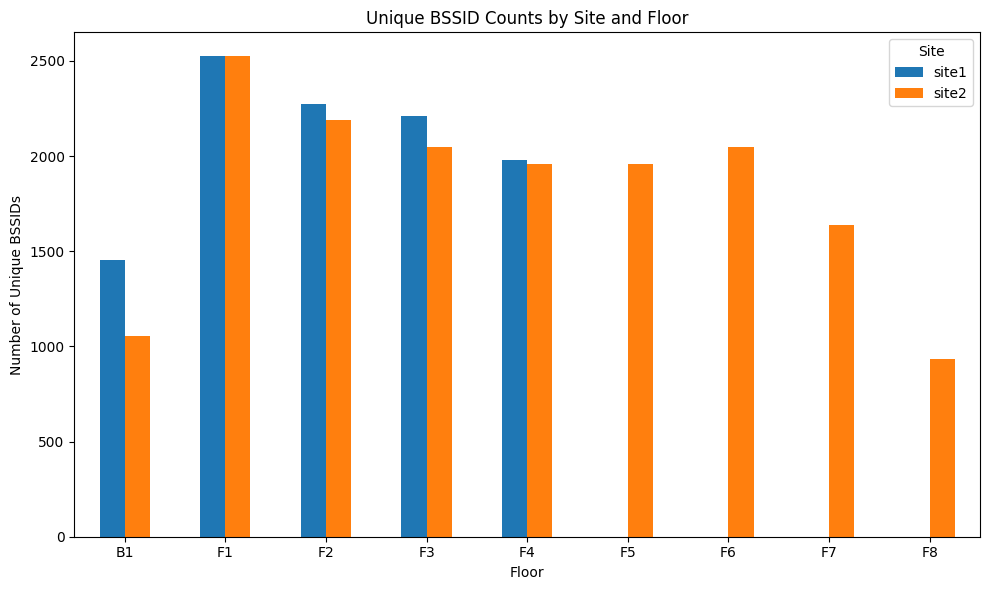

In [25]:

# Assuming you have the DataFrame 'final_dataframe' ready
grouped_data = final_dataframe.groupby(['site', 'floor'])['bssid'].nunique().reset_index()


# Pivot the data to create a suitable format for a grouped bar chart
pivot_df = grouped_data.pivot(index='floor', columns='site', values='bssid')

# Plotting a grouped bar chart
pivot_df.plot(kind='bar', figsize=(10, 6))

# Adding labels and title
plt.title('Unique BSSID Counts by Site and Floor')
plt.xlabel('Floor')
plt.ylabel('Number of Unique BSSIDs')
plt.xticks(rotation=0)

# Show the plot
plt.legend(title="Site")
plt.tight_layout()
plt.show()

In [26]:
final_dataframe.groupby(['site','floor','bssid']).size().reset_index(name='bssid_count')

site floor              bssid  bssid_count
0      site1    B1  00:03:0f:6e:71:60           15
1      site1    B1  00:03:7f:02:a0:08          226
2      site1    B1  00:1d:aa:91:76:bc           15
3      site1    B1  00:22:aa:ac:ea:2c          236
4      site1    B1  00:2f:d9:9c:61:17          234
...      ...   ...                ...          ...
26785  site2    F8  fe:ec:da:a7:d3:db          113
26786  site2    F8  fe:ec:da:a8:97:2c          174
26787  site2    F8  fe:ec:da:a8:99:6e          293
26788  site2    F8  fe:ec:da:a8:9e:4b          229
26789  site2    F8  fe:ec:da:a8:d3:db          236

[26790 rows x 4 columns]

C:\Users\perry\AppData\Local\Temp\ipykernel_15752\1656800879.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_bssid_per_floor = grouped_df.groupby(['site', 'floor']).apply(lambda x: x.nlargest(1, 'bssid_count')).reset_index(drop=True)


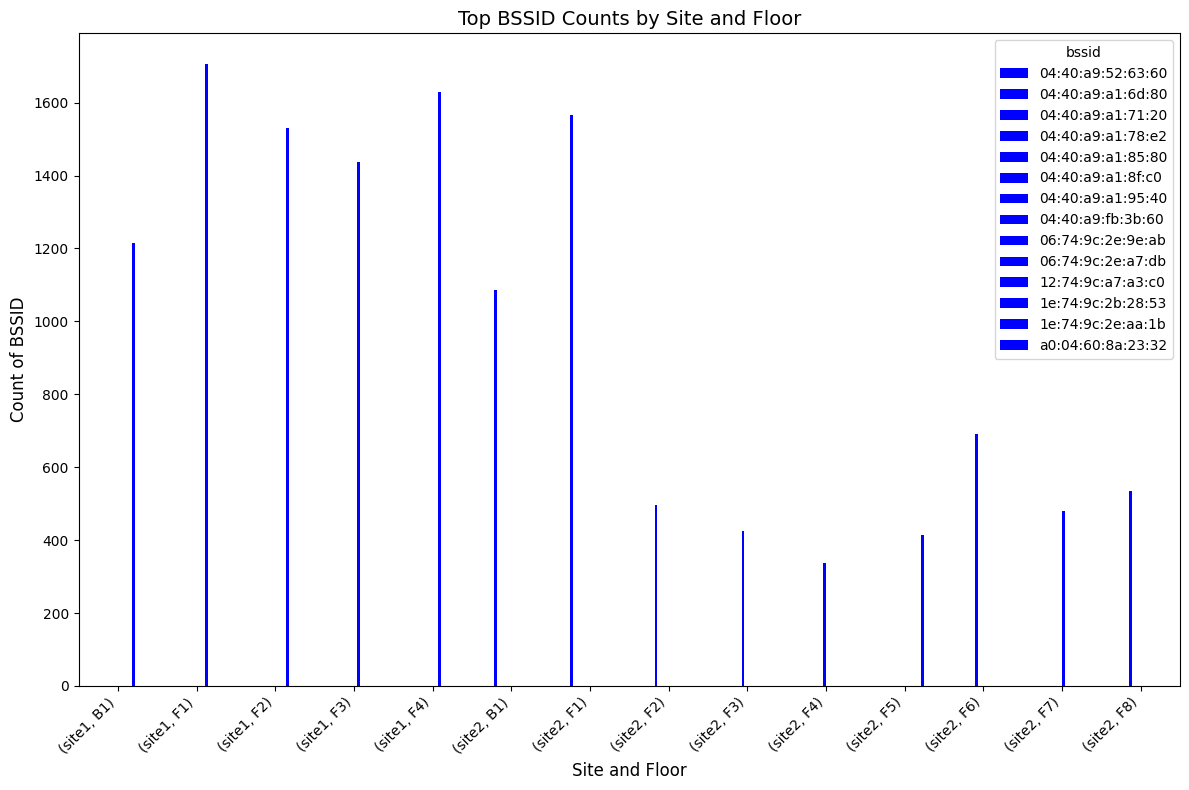

In [27]:

# Step 1: Grouping by 'site', 'floor', and 'bssid', and counting occurrences
grouped_df = final_dataframe.groupby(['site', 'floor', 'bssid']).size().reset_index(name='bssid_count')

# Step 2: For each combination of 'site' and 'floor', get the top 1 most popular BSSID
top_bssid_per_floor = grouped_df.groupby(['site', 'floor']).apply(lambda x: x.nlargest(1, 'bssid_count')).reset_index(drop=True)

# Step 3: Create a grouped bar chart
# Create a pivot table where rows are (site, floor), columns are BSSID, and values are bssid_count
pivot_top_bssid = top_bssid_per_floor.pivot_table(index=['site', 'floor'], columns='bssid', values='bssid_count', fill_value=0)

# Plotting the grouped bar chart
pivot_top_bssid.plot(kind='bar', figsize=(12, 8), color='blue')

# Adding labels and title
plt.title('Top BSSID Counts by Site and Floor', fontsize=14)
plt.xlabel('Site and Floor', fontsize=12)
plt.ylabel('Count of BSSID', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\perry\AppData\Local\Temp\ipykernel_15752\570944282.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_bssid_per_floor = grouped_df.groupby(['site', 'floor'], group_keys=False).apply(lambda x: x.nlargest(1, 'bssid_count')).reset_index(drop=True)


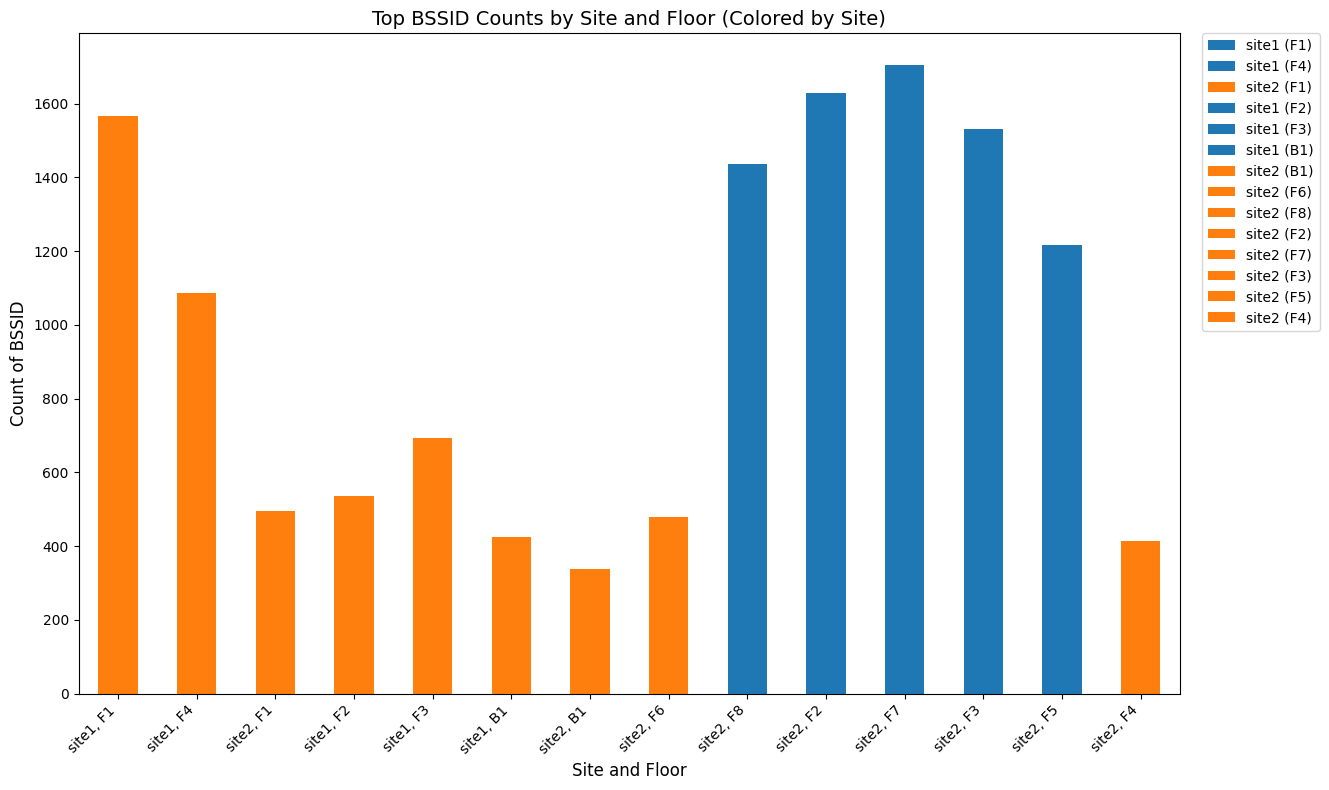

In [28]:

# Step 1: Grouping by 'site', 'floor', and 'bssid', and counting occurrences
grouped_df = final_dataframe.groupby(['site', 'floor', 'bssid']).size().reset_index(name='bssid_count')

# Step 2: For each combination of 'site' and 'floor', get the top 1 most popular BSSID
top_bssid_per_floor = grouped_df.groupby(['site', 'floor'], group_keys=False).apply(lambda x: x.nlargest(1, 'bssid_count')).reset_index(drop=True)

# Step 3: Ensure 'site' and 'floor' columns are retained
# Create a pivot table where rows are (site, floor), columns are BSSID, and values are bssid_count
pivot_top_bssid = top_bssid_per_floor.pivot_table(index=['site', 'floor'], columns='bssid', values='bssid_count', fill_value=0)

# Step 4: Sort the pivot table by the sum of each row (i.e., total count for each site-floor combination) in descending order
pivot_top_bssid_sorted = pivot_top_bssid.sum(axis=1).sort_values(ascending=False)
pivot_top_bssid = pivot_top_bssid.loc[pivot_top_bssid_sorted.index]

# Step 5: Create a color map for sites (assign a unique color to each unique site)
site_colors = {site: plt.cm.tab10(i) for i, site in enumerate(pivot_top_bssid.index.get_level_values('site').unique())}

# Step 6: Create a new figure and axes objects
plt.figure(figsize=(12, 8))

# Step 7: Plot the grouped bar chart, coloring bars based on the site
for (site, floor), row in pivot_top_bssid.iterrows():
    row.plot(kind='bar', color=[site_colors[site]] * len(row), ax=plt.gca(), label=f"{site} ({floor})")

# Step 8: Customize the x-axis labels to show both site and floor
x_labels = [f'{site}, {floor}' for site, floor in pivot_top_bssid.index]
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')

# Step 9: Add plot title, x-axis label, and y-axis label
plt.title('Top BSSID Counts by Site and Floor (Colored by Site)', fontsize=14)
plt.xlabel('Site and Floor', fontsize=12)
plt.ylabel('Count of BSSID', fontsize=12)

# Step 10: Adjust layout to prevent overlap
plt.tight_layout()

# Step 11: Place the legend outside the plot area to avoid overlap
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.0)

# Step 12: Display the plot
plt.show()

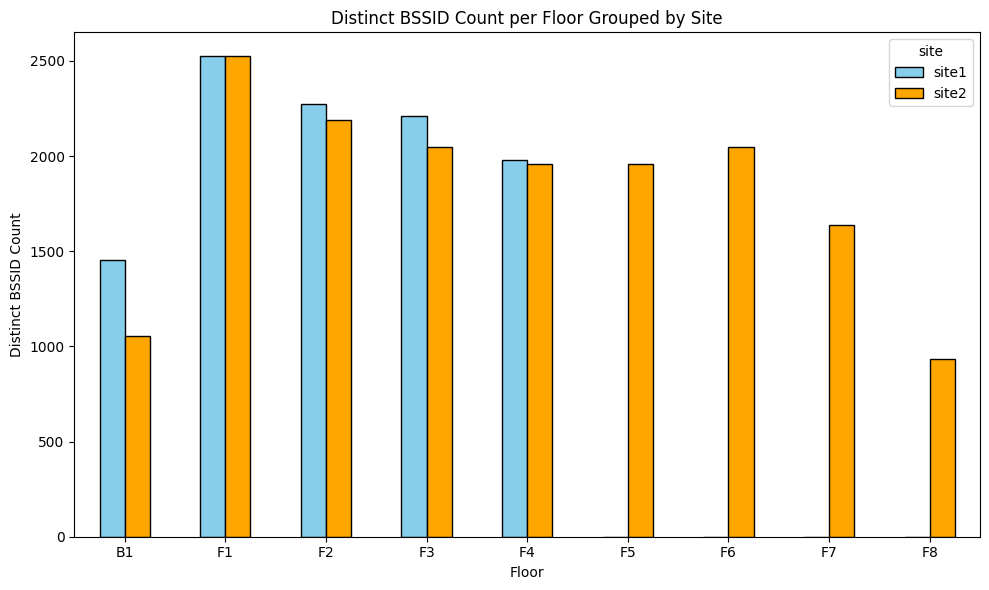

site floor  bssid
0   site1    B1   1452
1   site1    F1   2524
2   site1    F2   2272
3   site1    F3   2209
4   site1    F4   1982
5   site2    B1   1054
6   site2    F1   2524
7   site2    F2   2187
8   site2    F3   2048
9   site2    F4   1961
10  site2    F5   1960
11  site2    F6   2047
12  site2    F7   1636
13  site2    F8    934

In [29]:

# Group by 'site' and 'floor' and count distinct bssid
distinct_bssid_per_floor = final_dataframe.groupby(['site', 'floor'])['bssid'].nunique()

# Reset index to flatten the multi-index for easier plotting
distinct_bssid_per_floor = distinct_bssid_per_floor.reset_index()

# Pivot the table to make 'site' the category for grouped bars
pivot_data = distinct_bssid_per_floor.pivot(index='floor', columns='site', values='bssid')

# Plotting the result with grouped bars for each site
pivot_data.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'green', 'red', 'purple'], edgecolor='black')

plt.title('Distinct BSSID Count per Floor Grouped by Site')
plt.xlabel('Floor')
plt.ylabel('Distinct BSSID Count')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

distinct_bssid_per_floor


In [30]:
final_dataframe.columns

Index(['timestamp', 'acce_x', 'acce_y', 'acce_z', 'waypoint_x', 'waypoint_y',
       'sensor_type', 'site', 'floor', 'acce_uncali_x', 'acce_uncali_y',
       'acce_uncali_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_uncali_x',
       'gyro_uncali_y', 'gyro_uncali_z', 'magn_x', 'magn_y', 'magn_z',
       'magn_uncali_x', 'magn_uncali_y', 'magn_uncali_z', 'ahrs_x', 'ahrs_y',
       'ahrs_z', 'ssid', 'bssid', 'rssi', 'lastseen_ts', 'uuid_major_minor'],
      dtype='object')

In [31]:
sel_cols=['timestamp', 'waypoint_x', 'waypoint_y','sensor_type', 'site', 'floor', 'ssid', 'bssid', 'rssi', 'lastseen_ts']

df=final_dataframe[final_dataframe['sensor_type']=='WIFI'][sel_cols]

df.head()

timestamp waypoint_x waypoint_y sensor_type   site floor  \
6181  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6182  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6183  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6184  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6185  1574572524224  208.86206  216.74796        WIFI  site1    B1   

                      ssid              bssid rssi    lastseen_ts  
6181            intime_pos  06:74:9c:2e:9e:f3  -42  1574572523661  
6182         intime_office  0a:74:9c:2e:9e:f3  -42  1574572523662  
6183  cloud time_license_5  1e:74:9c:2e:9e:f3  -43  1574572523664  
6184           intime_free  0e:74:9c:2e:9e:f3  -43  1574572523662  
6185          intime_lease  12:74:9c:2e:9e:f3  -43  1574572523662

In [32]:
df.shape

(5674633, 10)

In [33]:
df.to_csv('wifi_data.csv', index=False)

In [34]:
# Get summary statistics of the bssid_count
summary_stats = distinct_bssid_per_floor.describe()

# Display the summary statistics
print(summary_stats)




             bssid
count    14.000000
mean   1913.571429
std     485.896272
min     934.000000
25%    1717.000000
50%    2014.500000
75%    2203.500000
max    2524.000000


# Data Augmentation

In [35]:
df.head()

timestamp waypoint_x waypoint_y sensor_type   site floor  \
6181  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6182  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6183  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6184  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6185  1574572524224  208.86206  216.74796        WIFI  site1    B1   

                      ssid              bssid rssi    lastseen_ts  
6181            intime_pos  06:74:9c:2e:9e:f3  -42  1574572523661  
6182         intime_office  0a:74:9c:2e:9e:f3  -42  1574572523662  
6183  cloud time_license_5  1e:74:9c:2e:9e:f3  -43  1574572523664  
6184           intime_free  0e:74:9c:2e:9e:f3  -43  1574572523662  
6185          intime_lease  12:74:9c:2e:9e:f3  -43  1574572523662

In [36]:
df.groupby(['site','floor','waypoint_x','waypoint_y'])['bssid'].nunique().describe()

count    3294.000000
mean      354.854281
std       197.693075
min        15.000000
25%       177.000000
50%       353.000000
75%       522.000000
max      1026.000000
Name: bssid, dtype: float64

In [37]:
df.groupby(['waypoint_x','waypoint_y'])['bssid'].nunique().sum()

np.int64(1168890)

In [38]:
df['bssid'].nunique()

8445

In [39]:
df.groupby(['site','floor','waypoint_x','waypoint_y']).nunique()

timestamp  sensor_type  ssid  bssid  rssi  \
site  floor waypoint_x waypoint_y                                              
site1 B1    101.733116 203.48077           8            1    49    228    48   
            103.26117  124.306915          7            1    33    110    51   
            104.69442  185.5976            5            1    50    153    38   
            106.005356 204.7234           11            1    51    216    52   
            106.2337   230.34064          14            1    36     84    36   
...                                      ...          ...   ...    ...   ...   
site2 F8    93.55758   92.08191            5            1    33     61    31   
            93.9174    138.35165           6            1    85    501    46   
            94.75684   129.76102           4            1    44    230    33   
            95.63964   177.451             2            1    47    327    41   
            97.6041    179.90727           4            1    58    383    44   

                                   lastseen_ts  
site  floor waypoint_x waypoint_y               
site1 B1    101.733116 203.48077           892  
            103.26117  124.306915          355  
            104.69442  185.5976            277  
            106.005356 204.7234           1252  
            106.2337   230.34064           224  
...                                        ...  
site2 F8    93.55758   92.08191            155  
            93.9174    138.35165          1387  
            94.75684   129.76102           304  
            95.63964   177.451             436  
            97.6041    179.90727           744  

[3294 rows x 6 columns]

In [40]:
df.groupby(['waypoint_x','waypoint_y']).size().reset_index(name='count')

waypoint_x waypoint_y  count
0     100.177124  171.41376   1343
1      100.50997  169.04027  10051
2      100.57797   153.3697   3073
3     100.868126  122.78847    429
4      100.89995  137.28639   2359
...          ...        ...    ...
3289    99.53583  228.24925    600
3290    99.74334  226.41035    180
3291    99.74619  185.13354    328
3292    99.75411  171.71259   1763
3293    99.83589  146.72423   2497

[3294 rows x 3 columns]

In [41]:
# Generate dynamic site mapping by sorting the unique site names
site_mapping = {site: idx for idx, site in enumerate(sorted(df['site'].unique()), start=1)}

# Generate dynamic floor mapping based on custom rules
def map_floor(floor):
    if floor.startswith('B'):
        # Negative values for basements
        return -int(floor[1:])
    elif floor.startswith('F'):
        # Positive values for floors
        return int(floor[1:])
    else:
        return None  # Handle any unexpected cases

# Apply the mapping to unique floor values
floor_mapping = {floor: map_floor(floor) for floor in df['floor'].unique()}

# Output the mappings
print("Site Mapping:", site_mapping)
print("Floor Mapping:", floor_mapping)

# Perform the mapping for site and floor
df['site_mapped'] = df['site'].map(site_mapping)
df['floor_mapped'] = df['floor'].map(floor_mapping)


Site Mapping: {'site1': 1, 'site2': 2}
Floor Mapping: {'B1': -1, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4, 'F5': 5, 'F6': 6, 'F7': 7, 'F8': 8}


In [42]:
# # Generate dynamic mappings for site and floor based on the unique values in the data
# site_mapping = {site: idx for idx, site in enumerate(df['site'].unique(), start=1)}
# floor_mapping = {floor: idx for idx, floor in enumerate(df['floor'].unique(), start=1)}

# Perform the mapping for site and floor
# df['site_mapped'] = df['site'].map(site_mapping)
# df['floor_mapped'] = df['floor'].map(floor_mapping)


# Ensure that 'rssi' is numeric
df['rssi'] = pd.to_numeric(df['rssi'], errors='coerce')  # Non-numeric values will be set to NaN



In [43]:
df=df.astype({'timestamp':'int', 'lastseen_ts':'int'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5674633 entries, 6181 to 24906706
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   timestamp     int64 
 1   waypoint_x    object
 2   waypoint_y    object
 3   sensor_type   object
 4   site          object
 5   floor         object
 6   ssid          object
 7   bssid         object
 8   rssi          int64 
 9   lastseen_ts   int64 
 10  site_mapped   int64 
 11  floor_mapped  int64 
dtypes: int64(5), object(7)
memory usage: 562.8+ MB


In [44]:
df

timestamp waypoint_x waypoint_y sensor_type   site floor  \
6181      1574572524224  208.86206  216.74796        WIFI  site1    B1   
6182      1574572524224  208.86206  216.74796        WIFI  site1    B1   
6183      1574572524224  208.86206  216.74796        WIFI  site1    B1   
6184      1574572524224  208.86206  216.74796        WIFI  site1    B1   
6185      1574572524224  208.86206  216.74796        WIFI  site1    B1   
...                 ...        ...        ...         ...    ...   ...   
24906702  1574679871683  154.20166  166.74393        WIFI  site2    F8   
24906703  1574679871683  154.20166  166.74393        WIFI  site2    F8   
24906704  1574679871683  154.20166  166.74393        WIFI  site2    F8   
24906705  1574679871683  154.20166  166.74393        WIFI  site2    F8   
24906706  1574679871683  154.20166  166.74393        WIFI  site2    F8   

                                ssid              bssid  rssi    lastseen_ts  \
6181                      intime_pos  06:74:9c:2e:9e:f3   -42  1574572523661   
6182                   intime_office  0a:74:9c:2e:9e:f3   -42  1574572523662   
6183            cloud time_license_5  1e:74:9c:2e:9e:f3   -43  1574572523664   
6184                     intime_free  0e:74:9c:2e:9e:f3   -43  1574572523662   
6185                    intime_lease  12:74:9c:2e:9e:f3   -43  1574572523662   
...                              ...                ...   ...            ...   
24906702                              04:40:a9:f9:d8:a2   -90  1574679854198   
24906703  YOCDke1gb7uIESyyPtCXuQRrQ7  a4:9b:4f:16:79:98   -90  1574679870165   
24906704                              04:40:a9:f9:d8:a1   -91  1574679868738   
24906705                      LinkUP  f4:28:53:d9:c9:a8   -91  1574679869832   
24906706                        BONA  88:df:9e:c5:ce:5f   -93  1574679855268   

          site_mapped  floor_mapped  
6181                1            -1  
6182                1            -1  
6183                1            -1  
6184                1            -1  
6185                1            -1  
...               ...           ...  
24906702            2             8  
24906703            2             8  
24906704            2             8  
24906705            2             8  
24906706            2             8  

[5674633 rows x 12 columns]

In [45]:
df.to_csv('wifi_data.csv', index=False)

In [46]:

# Group by 'site', 'floor', and 'bssid' and calculate max, min, and average rssi
aggregated_df = df.groupby(['site_mapped', 'floor_mapped', 'bssid']).agg(
    min_rssi=('rssi', 'min'),
    max_rssi=('rssi', 'max'),
    avg_rssi=('rssi', 'mean'),
    waypoint_x=('waypoint_x', 'first'),
    waypoint_y=('waypoint_y', 'first')
).reset_index()

# Rename columns for clarity
aggregated_df.rename(columns={
    'site_mapped': 'site',
    'floor_mapped': 'floor',
    'bssid': 'unique_bssid'
}, inplace=True)

# Display the result
print(aggregated_df)
print("Site Mapping:", site_mapping)
print("Floor Mapping:", floor_mapping)



       site  floor       unique_bssid  min_rssi  max_rssi   avg_rssi  \
0         1     -1  00:03:0f:6e:71:60       -88       -88 -88.000000   
1         1     -1  00:03:7f:02:a0:08       -93       -54 -77.964602   
2         1     -1  00:1d:aa:91:76:bc       -88       -88 -88.000000   
3         1     -1  00:22:aa:ac:ea:2c       -90       -65 -75.529661   
4         1     -1  00:2f:d9:9c:61:17       -83       -62 -76.106838   
...     ...    ...                ...       ...       ...        ...   
26785     2      8  fe:ec:da:a7:d3:db       -82       -59 -74.097345   
26786     2      8  fe:ec:da:a8:97:2c       -90       -77 -85.919540   
26787     2      8  fe:ec:da:a8:99:6e       -90       -71 -82.965870   
26788     2      8  fe:ec:da:a8:9e:4b       -92       -76 -83.650655   
26789     2      8  fe:ec:da:a8:d3:db       -89       -73 -82.228814   

      waypoint_x waypoint_y  
0      114.62859  106.19728  
1      184.57188  98.733574  
2       200.4127  151.22377  
3      114.6285

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5674633 entries, 6181 to 24906706
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   timestamp     int64 
 1   waypoint_x    object
 2   waypoint_y    object
 3   sensor_type   object
 4   site          object
 5   floor         object
 6   ssid          object
 7   bssid         object
 8   rssi          int64 
 9   lastseen_ts   int64 
 10  site_mapped   int64 
 11  floor_mapped  int64 
dtypes: int64(5), object(7)
memory usage: 562.8+ MB


In [48]:
df.groupby(['waypoint_x','waypoint_y']).agg(
    min_rssi=('rssi', 'min'),
    max_rssi=('rssi', 'max'),
    avg_rssi=('rssi', 'mean'),
).reset_index()

waypoint_x waypoint_y  min_rssi  max_rssi   avg_rssi
0     100.177124  171.41376       -91       -40 -78.002234
1      100.50997  169.04027       -93       -28 -75.761914
2      100.57797   153.3697       -92       -40 -74.262935
3     100.868126  122.78847       -92       -60 -82.890443
4      100.89995  137.28639       -92       -42 -76.063162
...          ...        ...       ...       ...        ...
3289    99.53583  228.24925       -93       -54 -82.603333
3290    99.74334  226.41035       -93       -48 -83.866667
3291    99.74619  185.13354       -93       -44 -80.070122
3292    99.75411  171.71259       -91       -33 -76.937039
3293    99.83589  146.72423       -91       -35 -74.290749

[3294 rows x 5 columns]

In [49]:
aggregated_df.head()

site  floor       unique_bssid  min_rssi  max_rssi   avg_rssi waypoint_x  \
0     1     -1  00:03:0f:6e:71:60       -88       -88 -88.000000  114.62859   
1     1     -1  00:03:7f:02:a0:08       -93       -54 -77.964602  184.57188   
2     1     -1  00:1d:aa:91:76:bc       -88       -88 -88.000000   200.4127   
3     1     -1  00:22:aa:ac:ea:2c       -90       -65 -75.529661  114.62859   
4     1     -1  00:2f:d9:9c:61:17       -83       -62 -76.106838  114.62859   

  waypoint_y  
0  106.19728  
1  98.733574  
2  151.22377  
3  106.19728  
4  106.19728

In [50]:
aggregated_df.groupby(['site']).size().reset_index(name='count')

site  count
0     1  10439
1     2  16351

In [51]:
aggregated_df.groupby(['site','floor']).size().reset_index(name='count')

site  floor  count
0      1     -1   1452
1      1      1   2524
2      1      2   2272
3      1      3   2209
4      1      4   1982
5      2     -1   1054
6      2      1   2524
7      2      2   2187
8      2      3   2048
9      2      4   1961
10     2      5   1960
11     2      6   2047
12     2      7   1636
13     2      8    934

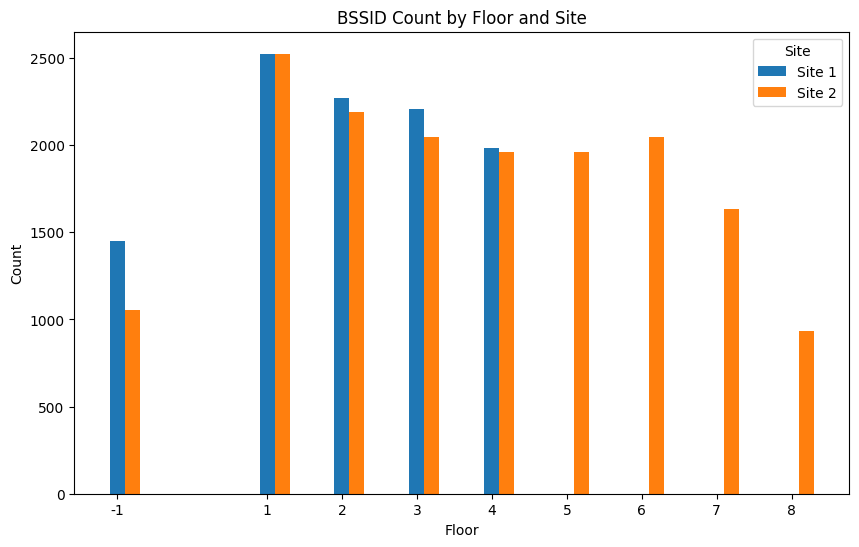

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

temp_df=aggregated_df.groupby(['site','floor']).size().reset_index(name='count')

bar_width=0.2
# Plot multi-bar chart
plt.figure(figsize=(10, 6))
for site in temp_df['site'].unique():
    subset = temp_df[temp_df['site'] == site]
    plt.bar(subset['floor'] + (site* bar_width), subset['count'], width=bar_width, label=f'Site {site}')

plt.xlabel('Floor')
plt.ylabel('Count')
plt.title('BSSID Count by Floor and Site')
plt.xticks(temp_df['floor'].unique().astype(int) + bar_width, temp_df['floor'].unique())  # Center the ticks with bars
plt.legend(title='Site')

# Display the plot
plt.show()


In [53]:
df.head()

timestamp waypoint_x waypoint_y sensor_type   site floor  \
6181  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6182  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6183  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6184  1574572524224  208.86206  216.74796        WIFI  site1    B1   
6185  1574572524224  208.86206  216.74796        WIFI  site1    B1   

                      ssid              bssid  rssi    lastseen_ts  \
6181            intime_pos  06:74:9c:2e:9e:f3   -42  1574572523661   
6182         intime_office  0a:74:9c:2e:9e:f3   -42  1574572523662   
6183  cloud time_license_5  1e:74:9c:2e:9e:f3   -43  1574572523664   
6184           intime_free  0e:74:9c:2e:9e:f3   -43  1574572523662   
6185          intime_lease  12:74:9c:2e:9e:f3   -43  1574572523662   

      site_mapped  floor_mapped  
6181            1            -1  
6182            1            -1  
6183            1            -1  
6184            1            -1  
6185            1            -1

## Create site,floor and bbsid mappings

In [54]:

# Mapping between site and site_mapped
site_mapping = dict(zip(df['site'], df['site_mapped']))

# Mapping between floor and floor_mapped
floor_mapping = dict(zip(df['floor'], df['floor_mapped']))

# Mapping between unique bssid and integer number
unique_bssids = df['bssid'].unique()
bssid_mapping = {bssid: i for i, bssid in enumerate(unique_bssids)}


# Create a set of unique waypoints
unique_waypoints = set(zip(df['waypoint_x'], df['waypoint_y']))

# Mapping between unique waypoints and integer number
waypoint_mapping = {waypoint: i for i, waypoint in enumerate(unique_waypoints)}

print("Waypoint Mapping:", waypoint_mapping)

print("Site Mapping:", site_mapping)
print("Floor Mapping:", floor_mapping)
print("BSSID Mapping:", bssid_mapping)

Waypoint Mapping: {('206.17526', '17.835064'): 0, ('235.2973', '109.05914'): 1, ('31.05889', '112.723015'): 2, ('219.96861', '98.72473'): 3, ('257.56436', '222.99161'): 4, ('220.82872', '122.22351'): 5, ('73.95977', '157.46213'): 6, ('147.22318', '105.856804'): 7, ('183.60065', '26.284172'): 8, ('175.48152', '73.86302'): 9, ('146.76369', '122.35484'): 10, ('164.27016', '100.535446'): 11, ('144.73532', '172.04134'): 12, ('155.00862', '67.96831'): 13, ('44.24984', '43.77227'): 14, ('66.59882', '168.4582'): 15, ('203.45142', '59.33115'): 16, ('232.62178', '98.9326'): 17, ('94.58673', '175.88843'): 18, ('105.30832', '110.62216'): 19, ('169.71191', '110.599655'): 20, ('140.97073', '140.34042'): 21, ('53.902504', '139.55263'): 22, ('110.664734', '121.459465'): 23, ('154.41902', '245.61406'): 24, ('146.77556', '77.16182'): 25, ('154.24696', '127.00561'): 26, ('195.22359', '125.0103'): 27, ('194.48424', '73.349846'): 28, ('113.135544', '147.90477'): 29, ('227.96227', '179.96063'): 30, ('87.535

In [55]:
df['bssid_mapping']=df['bssid'].map(bssid_mapping)
df['waypoint_mapping']=df[['waypoint_x','waypoint_y']].apply(tuple, axis=1).map(waypoint_mapping)

df.to_csv('wifi_data.csv', index=False)

In [56]:
# Save mappings to JSON files
with open('site_mapping.json', 'w') as f:
    json.dump(site_mapping, f, indent=4)

with open('floor_mapping.json', 'w') as f:
    json.dump(floor_mapping, f, indent=4)

with open('bssid_mapping.json', 'w') as f:
    json.dump(bssid_mapping, f, indent=4)
    
# Convert waypoint tuples to strings for JSON serialization
waypoint_mapping_str = {str(waypoint): i for waypoint, i in waypoint_mapping.items()}

with open('waypoint_mapping.json', 'w') as f:
    json.dump(waypoint_mapping_str, f, indent=4)

In [57]:
#Test the Loading and Mapping of the JSON files 
# Load mappings from JSON files
with open('site_mapping.json', 'r') as f:
    site_mapping = json.load(f)

with open('floor_mapping.json', 'r') as f:
    floor_mapping = json.load(f)

with open('bssid_mapping.json', 'r') as f:
    bssid_mapping = json.load(f)


def map_bssid(bssid):
    if bssid in bssid_mapping:
        return bssid_mapping[bssid]
    else:
        global max_bssid_value  # Access the global variable
        max_bssid_value += 1
        return max_bssid_value

#Load the waypoint mapping from the JSON file
with open('waypoint_mapping.json', 'r') as f:
    waypoint_mapping_str = json.load(f)
    # Convert string keys back to tuples
    waypoint_mapping = {eval(k): v for k, v in waypoint_mapping_str.items()}

def map_waypoint(x, y):
  """
  Maps a pair of waypoint_x and waypoint_y to an integer using the waypoint_mapping.

  Args:
    x: The value of waypoint_x.
    y: The value of waypoint_y.

  Returns:
    The mapped waypoint number if found in the mapping, otherwise None.
  """
  return waypoint_mapping.get((str(x), str(y)))


In [58]:
#test the waypoint mapping function
map_waypoint(108.13564, 116.79779)

# # Sample data (replace with your actual DataFrame)
# temp_data = {
#     'waypoint_x': [44.210052, 23.413315, 62.67382, 51.761837, 44.210052],
#     'waypoint_y': [47.231945, 44.489456, 46.510468, 44.695847, 47.231945]
# }
# temp_wp = pd.DataFrame(temp_data)

# # Map waypoint_x and waypoint_y to integers
# temp_wp['waypoint_mapped'] = temp_wp.apply(lambda row: waypoint_mapping.get((str(row['waypoint_x']), str(row['waypoint_y']))), axis=1)

# print(temp_wp)

86

In [59]:

# Sample new data (replace with your actual data)
new_data = {
    'site': ['5cd56865eb294480de7167b6', '5cdac61de403deddaf467f4f'],
    'floor': ['F4', 'F3'],  # Assuming F3 is a new floor
    'bssid': ['584ff3f74810391c28f1327321702c2c02e9581d', '584ff3f74810391c28f1327321702c2c02e958zz']  # Assuming new_bssid is a new BSSID
}
new_df = pd.DataFrame(new_data)

# Map site, floor, and bssid in the new data
new_df['site_mapped'] = new_df['site'].map(site_mapping)
new_df['floor_mapped'] = new_df['floor'].map(floor_mapping)

# For new BSSIDs, assign a new integer value
max_bssid_value = max(bssid_mapping.values())

new_df['bssid_mapped'] = new_df['bssid'].apply(map_bssid)

print(new_df)

                       site floor                                     bssid  \
0  5cd56865eb294480de7167b6    F4  584ff3f74810391c28f1327321702c2c02e9581d   
1  5cdac61de403deddaf467f4f    F3  584ff3f74810391c28f1327321702c2c02e958zz   

   site_mapped  floor_mapped  bssid_mapped  
0          NaN             4          8445  
1          NaN             3          8446  


## Creating RSSI Fingerprints

In [60]:
data=pd.read_csv("wifi_data.csv")
data.head()

timestamp  waypoint_x  waypoint_y sensor_type   site floor  \
0  1574572524224   208.86206   216.74796        WIFI  site1    B1   
1  1574572524224   208.86206   216.74796        WIFI  site1    B1   
2  1574572524224   208.86206   216.74796        WIFI  site1    B1   
3  1574572524224   208.86206   216.74796        WIFI  site1    B1   
4  1574572524224   208.86206   216.74796        WIFI  site1    B1   

                   ssid              bssid  rssi    lastseen_ts  site_mapped  \
0            intime_pos  06:74:9c:2e:9e:f3   -42  1574572523661            1   
1         intime_office  0a:74:9c:2e:9e:f3   -42  1574572523662            1   
2  cloud time_license_5  1e:74:9c:2e:9e:f3   -43  1574572523664            1   
3           intime_free  0e:74:9c:2e:9e:f3   -43  1574572523662            1   
4          intime_lease  12:74:9c:2e:9e:f3   -43  1574572523662            1   

   floor_mapped  bssid_mapping  waypoint_mapping  
0            -1              0              3212  
1            -1              1              3212  
2            -1              2              3212  
3            -1              3              3212  
4            -1              4              3212

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5674633 entries, 0 to 5674632
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   timestamp         int64  
 1   waypoint_x        float64
 2   waypoint_y        float64
 3   sensor_type       object 
 4   site              object 
 5   floor             object 
 6   ssid              object 
 7   bssid             object 
 8   rssi              int64  
 9   lastseen_ts       int64  
 10  site_mapped       int64  
 11  floor_mapped      int64  
 12  bssid_mapping     int64  
 13  waypoint_mapping  int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 606.1+ MB


In [62]:
# Load the bssid mapping

with open('bssid_mapping.json', 'r') as f:
    bssid_mapping = json.load(f)


# Total number of APs (N)
N = len(bssid_mapping)
print(f'Total number of APs : {N}')
# Step 1: Create RSSI fingerprints as vectors for each Reference Point (RP)
# Group data by 'waypoint_x' and 'waypoint_y'
grouped = data.groupby(['waypoint_x', 'waypoint_y'])

Total number of APs : 8445


In [63]:
data.groupby(['waypoint_x', 'waypoint_y']).nunique().count()['site']    

np.int64(3294)

In [64]:
data.groupby(['waypoint_mapping','timestamp', 'site_mapped','floor_mapped']).nunique()['bssid']


waypoint_mapping  timestamp      site_mapped  floor_mapped
0                 1574595894660  1            3               226
                  1574595896677  1            3               227
                  1574595898728  1            3               229
                  1574596031000  1            3                67
                  1574596032915  1            3                67
                                                             ... 
3292              1574568851862  1            2               170
                  1574568950279  1            2               175
                  1574568952253  1            2               178
                  1574568954236  1            2               174
3293              1574145856610  2            3                57
Name: bssid, Length: 20065, dtype: int64

In [65]:
data.groupby(['waypoint_mapping','timestamp']).nunique()['bssid'].describe()

count    20065.000000
mean       281.893247
std        157.897617
min          5.000000
25%        141.000000
50%        279.000000
75%        415.000000
max        733.000000
Name: bssid, dtype: float64

In [66]:
for rp_index, group in grouped:
    print(f'RP Index: {rp_index}')
    print(group[['bssid_mapping', 'rssi']])

RP Index: (np.float64(13.783575), np.float64(65.146645))
         bssid_mapping  rssi
3983465           6258   -42
3983466           6257   -43
3983467           6042   -43
3983468           5998   -46
3983469           5914   -47
...                ...   ...
4225927           4393   -91
4225928           4376   -91
4225929           6341   -91
4225930           6165   -91
4225931           6318   -92

[5423 rows x 2 columns]
RP Index: (np.float64(15.125112), np.float64(62.026543))
         bssid_mapping  rssi
3984370           5914   -40
3984371           5793   -40
3984372           6258   -42
3984373           6257   -43
3984374           6042   -43
...                ...   ...
4226366           4393   -91
4226367           4376   -91
4226368           6341   -91
4226369           6165   -91
4226370           6318   -92

[4617 rows x 2 columns]
RP Index: (np.float64(16.48848), np.float64(59.67796))
         bssid_mapping  rssi
4003503           5998   -34
4003504           5921   -4

In [67]:
bssid_mapping

{'06:74:9c:2e:9e:f3': 0,
 '0a:74:9c:2e:9e:f3': 1,
 '1e:74:9c:2e:9e:f3': 2,
 '0e:74:9c:2e:9e:f3': 3,
 '12:74:9c:2e:9e:f3': 4,
 '16:74:9c:2e:9e:f3': 5,
 '06:74:9c:2e:9e:f2': 6,
 '0e:74:9c:2e:9e:f2': 7,
 '12:74:9c:2e:9e:f2': 8,
 '0a:74:9c:2e:9e:f2': 9,
 '16:74:9c:2e:9e:f2': 10,
 '1a:74:9c:2e:9e:f2': 11,
 'a0:c5:f2:b0:e5:70': 12,
 '24:da:33:7b:3f:bd': 13,
 '24:da:33:7b:3f:b9': 14,
 'ec:f8:eb:47:43:a1': 15,
 '54:e0:61:54:e3:a9': 16,
 '16:74:9c:2e:af:5b': 17,
 '0a:74:9c:2e:af:5a': 18,
 '1a:74:9c:2e:af:5a': 19,
 '24:da:33:7b:3f:b8': 20,
 '06:74:9c:2e:af:5a': 21,
 '0e:74:9c:2e:af:5a': 22,
 '12:74:9c:2e:af:5a': 23,
 '0a:74:9c:2e:af:5b': 24,
 '0e:74:9c:2e:af:5b': 25,
 '12:74:9c:2e:af:5b': 26,
 '50:fa:84:80:46:50': 27,
 '1e:74:9c:2e:af:5b': 28,
 '9c:a6:15:b0:23:8e': 29,
 '06:74:9c:2e:af:5b': 30,
 'b0:df:c1:38:71:11': 31,
 '50:d2:f5:01:4a:4d': 32,
 '0e:74:9c:2e:aa:1a': 33,
 '06:74:9c:2e:aa:1a': 34,
 '1a:74:9c:2e:aa:1a': 35,
 '94:d9:b3:79:6a:c5': 36,
 '0a:74:9c:2e:aa:1a': 37,
 '12:74:9c:2e:aa:1a': 

In [68]:
# for rp_index, group in grouped:
#     print(rp_index)
#     print(map_waypoint(rp_index[0],rp_index[1]))

## Create 2D Image

In [69]:
df.columns

Index(['timestamp', 'waypoint_x', 'waypoint_y', 'sensor_type', 'site', 'floor',
       'ssid', 'bssid', 'rssi', 'lastseen_ts', 'site_mapped', 'floor_mapped',
       'bssid_mapping', 'waypoint_mapping'],
      dtype='object')

In [70]:
import os
import numpy as np
from PIL import Image

# Ensure the "image_data" directory exists
if not os.path.exists("image_data"):
    os.makedirs("image_data")

unique_RPs = data.groupby(['waypoint_x', 'waypoint_y']).nunique().count()['site']

# Group the data by 'timestamp', 'site_mapped', 'floor_mapped', 'waypoint_x', and 'waypoint_y' (RP)
grouped = data.groupby(['timestamp', 'site_mapped', 'floor_mapped', 'waypoint_x', 'waypoint_y'])

# Create a mapping for BSSIDs (APs) to indices
bssid_mapping = {bssid: idx for idx, bssid in enumerate(data['bssid'].unique())}

# Set N based on the number of unique BSSIDs
N = len(bssid_mapping)

# Step 1: Precompute the max/min RSSI values for each BSSID (outside the loop to avoid repetitive filtering)
rssi_stats = data.groupby('bssid')['rssi'].agg(['max', 'min']).to_dict()

# For each RP (grouped by 'site', 'floor', 'waypoint_x', 'waypoint_y'), create the RSSI fingerprint vector
for group_index, group in grouped:
    # Extract timestamp, site, floor, waypoint_x, and waypoint_y from group_index
    timestamp, site_mapped, floor_mapped, waypoint_x, waypoint_y = group_index
    print(f"Site: {site_mapped}, Floor: {floor_mapped}, RP: ({waypoint_x}, {waypoint_y})")
    
    # Initialize the fingerprint vector with -100 dB for the first channel, max, and min RSSI channels
    fingerprint_vector = np.full((N, 3), -100.0)  # 3 channels: original, max, min

    # Optimized: Pre-group by 'bssid' to avoid nested loops
    grouped_bssid = group.groupby('bssid')
    
    for bssid, bssid_group in grouped_bssid:
        # Get the index of the BSSID in the fingerprint vector
        index = bssid_mapping[bssid]
        
        # Get the RSSI values for this BSSID
        max_rssi = rssi_stats['max'][bssid]
        min_rssi = rssi_stats['min'][bssid]
        
        # Set the original RSSI, max, and min RSSI in the fingerprint vector
        fingerprint_vector[index, 0] = bssid_group['rssi'].values[0]  # Original RSSI (use the first one in the group)
        fingerprint_vector[index, 1] = max_rssi    # Max RSSI value
        fingerprint_vector[index, 2] = min_rssi    # Min RSSI value
    
    # Step 2: Create 3-channel "image"
    num_repeats = int(unique_RPs/20)
    expanded_vector = np.tile(fingerprint_vector, (num_repeats, 1, 1))  # Repeat along rows
    
    # Step 3: Convert the 1D image into a 2D image by replication
    image_2d_scaled = np.zeros((num_repeats, N, 3), dtype=np.uint8)  # Create an empty array for the 3-channel image
    
    # Scale each channel (Original, Max, Min RSSI) from (-100, 0) to (0, 255), ensuring values stay in range
    for channel in range(3):
        image_2d_scaled[:, :, channel] = np.clip(((expanded_vector[:, :, channel] + 100) / 100 * 255), 0, 255).astype(np.uint8)
    
    # Convert to an image (PIL) with mode 'RGB' for 3 channels
    image = Image.fromarray(image_2d_scaled, mode='RGB')
    
    # Construct the filename based on site, floor, and reference point (RP)
    rp_index = map_waypoint(waypoint_x, waypoint_y)
    counter = 1
    filename = f"site_{site_mapped}_floor_{floor_mapped}_RP_{rp_index}_{counter}.jpg"
    filepath = os.path.join("image_data", filename)
    
    # Increment filename if it already exists
    while os.path.exists(filepath):
        counter += 1
        filename = f"site_{site_mapped}_floor_{floor_mapped}_RP_{rp_index}_{counter}.jpg"
        filepath = os.path.join("image_data", filename)

    # Save the image in JPG format
    image.save(filepath)
    print(f"Image saved at {filepath}")


Site: 2, Floor: 1, RP: (154.62883, 130.06526)
Image saved at image_data\site_2_floor_1_RP_2157_1.jpg
Site: 2, Floor: 1, RP: (154.62883, 130.06526)
Image saved at image_data\site_2_floor_1_RP_2157_2.jpg
Site: 2, Floor: 1, RP: (151.97913, 128.23132)
Image saved at image_data\site_2_floor_1_RP_718_1.jpg
Site: 2, Floor: 1, RP: (151.97913, 128.23132)
Image saved at image_data\site_2_floor_1_RP_718_2.jpg
Site: 2, Floor: 1, RP: (151.97913, 128.23132)
Image saved at image_data\site_2_floor_1_RP_718_3.jpg
Site: 2, Floor: 1, RP: (151.97913, 128.23132)
Image saved at image_data\site_2_floor_1_RP_718_4.jpg
Site: 2, Floor: 1, RP: (162.1616, 119.955154)
Image saved at image_data\site_2_floor_1_RP_911_1.jpg
Site: 2, Floor: 1, RP: (162.1616, 119.955154)
Image saved at image_data\site_2_floor_1_RP_911_2.jpg
Site: 2, Floor: 1, RP: (162.1616, 119.955154)
Image saved at image_data\site_2_floor_1_RP_911_3.jpg
Site: 2, Floor: 1, RP: (162.1616, 119.955154)
Image saved at image_data\site_2_floor_1_RP_911_4.jp